In [1]:
%load_ext autoreload
%load_ext autotime

time: 229 µs (started: 2024-12-12 19:46:32 -08:00)


In [2]:
import os
import sys
import time
import warnings
from bokeh.io import output_notebook

# Add WisIO to the path
sys.path.append(os.path.abspath("../"))

# Filter warnings
warnings.filterwarnings('ignore')

# Set the notebook to display Bokeh plots
output_notebook()

Loading BokehJS ...

time: 608 ms (started: 2024-12-12 19:46:32 -08:00)


In [3]:
analyzer = "dftracer"

run_dir = f".wisio/{analyzer}/{int(time.time())}"
bottleneck_dir = f"{run_dir}/bottlenecks"
checkpoint_dir = f"{run_dir}/checkpoints"

cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:46423"

checkpoint = False
exclude_characteristics = ['node_count', 'app_count', 'proc_count', 'file_count']
logical_view_types = False
percentile = 0.95
time_granularity = 1e6
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cm1/APP/node-1/v1/RAW/*.pfw.gz"

app_metrics = [
    'intensity',
    'io_compute_per',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    'time_norm',
    'time_per',
    # 'u_checkpoint_io_time',
    # 'u_io_time_per',
    # 'u_read_io_time',
]
dataloader_metrics = [
    'intensity',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]
posix_metrics = [
    'intensity',
    'data_bw',
    'data_time_norm',
    'data_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]

app_view_types = ['proc_name', 'time_range']
dataloader_view_types = ['proc_name', 'time_range']
posix_view_types = ['proc_name', 'time_range']

time_view_type = 'time_range'
unoverlapped_posix_only = False

output_compact = False
output_group_behavior = False
output_max_bottlenecks = 1
output_root_only = True


time: 1.57 ms (started: 2024-12-12 19:46:32 -08:00)


In [4]:
# Parameters
analyzer = "dftracer"
bottleneck_dir = "/p/lustre3/iopp/wisio-bottlenecks/dftracer-cosmoflow-dlio-v100-node-4-v1-proc_name-time_range"
checkpoint = True
checkpoint_dir = "/p/lustre3/iopp/wisio-checkpoints/dftracer-cosmoflow-dlio-v100-node-4-v1-proc_name-time_range"
cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:36047"
logical_view_types = False
output_max_bottlenecks = 3
output_root_only = False
percentile = 0.6
run_dir = ".wisio/dftracer-cosmoflow-dlio-v100-node-4-v1-proc_name-time_range"
time_granularity = 3000000.0
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cosmoflow/dlio-v100/node-4/v1/COMPACT/*.pfw.gz"

app_view_types = ["proc_name", "time_range"]
dataloader_view_types = ["proc_name", "time_range"]
posix_view_types = ["proc_name", "time_range"]


time: 1.09 ms (started: 2024-12-12 19:46:36 -08:00)


In [5]:
from distributed import Client
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from wisio.cluster import ExternalCluster
from wisio.config import init_hydra_config_store
from wisio.utils.file_utils import ensure_dir

ensure_dir(run_dir)

with initialize(version_base=None, config_path=None):
    init_hydra_config_store()
    cfg = compose(
        config_name="config",
        overrides=[
            f"+analyzer={analyzer}",
            f"analyzer.bottleneck_dir={bottleneck_dir}",
            f"analyzer.checkpoint={checkpoint}",
            f"analyzer.checkpoint_dir={checkpoint_dir}",
            f"analyzer.time_granularity={time_granularity}",
            # f"cluster={cluster}",
            # f"cluster.restart_on_connect={cluster_restart_on_connect}",
            # f"cluster.scheduler_address={cluster_scheduler_address}",
            "cluster=external",
            "cluster.scheduler_address=tcp://127.0.0.1:46065",
            f"exclude_characteristics=[{','.join(exclude_characteristics)}]",
            f"hydra.run.dir={run_dir}",
            f"hydra.runtime.output_dir={run_dir}",
            f"logical_view_types={logical_view_types}",
            f"output.compact={output_compact}",
            f"output.group_behavior={output_group_behavior}",
            f"output.max_bottlenecks={output_max_bottlenecks}",
            f"output.root_only={output_root_only}",
            f"percentile={percentile}",
            f"trace_path={trace_path}",
        ],
        return_hydra_config=True,
    )
    HydraConfig.instance().set_config(cfg)
    cluster = instantiate(cfg.cluster)
    if isinstance(cluster, ExternalCluster):
        client = Client(cluster.scheduler_address)
        if cluster.restart_on_connect:
            client.restart()
    else:
        client = Client(cluster)
    analyzer = instantiate(cfg.analyzer)
    output = instantiate(cfg.output)

time: 3.29 s (started: 2024-12-12 19:46:40 -08:00)


In [6]:
client.dashboard_link

'http://127.0.0.1:8787/status'

time: 7.27 ms (started: 2024-12-12 19:46:43 -08:00)


In [7]:
client.restart()

<Client: 'tcp://127.0.0.1:46065' processes=0 threads=0, memory=0 B>

time: 3.17 s (started: 2024-12-12 19:46:43 -08:00)


In [8]:
from wisio.constants import Layer

result = analyzer.analyze_trace(
    trace_path=cfg.trace_path,
    bottleneck_rules=cfg.bottleneck_rules,
    exclude_bottlenecks=cfg.exclude_bottlenecks,
    exclude_characteristics=cfg.exclude_characteristics,
    logical_view_types=cfg.logical_view_types,
    percentile=cfg.percentile,
    metrics={
        'dlio': app_metrics,
        'compute': app_metrics,
        'dataloader': dataloader_metrics,
        'image': dataloader_metrics,
        'reader': dataloader_metrics,
        'checkpoint': dataloader_metrics,
        'posix': posix_metrics,
    },
    time_view_type=time_view_type,
    unoverlapped_posix_only=unoverlapped_posix_only,
    view_types={
        'dlio': app_view_types,
        'compute': app_view_types,
        'dataloader': dataloader_view_types,
        'image': dataloader_view_types,
        'reader': dataloader_view_types,
        'checkpoint': dataloader_view_types,
        'posix': posix_view_types,
    },
)

time: 8min 9s (started: 2024-12-12 19:46:47 -08:00)


In [10]:
traces, hlms, main_views, metric_boundaries, views, flat_views = result

time: 803 µs (started: 2024-12-12 19:57:41 -08:00)


In [15]:
traces.to_parquet(f"{checkpoint_dir}/_traces", write_metadata_file=True)

time: 21.3 s (started: 2024-12-12 19:58:37 -08:00)


In [14]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'posix_read_lustre_time',
        'posix_read_ssd_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                776.239309
checkpoint_time               0.431292
dlio_compute_time           901.676482
dlio_stall_time              44.555595
dataloader_time             172.205879
dataloader_sample_time             0.0
posix_time                  351.431483
posix_read_lustre_time      336.130881
posix_read_ssd_time                0.0
u_checkpoint_time             0.431292
u_dataloader_time           172.205879
u_dataloader_sample_time           0.0
u_posix_time                  3.296051
dtype: double[pyarrow]

time: 6.43 ms (started: 2024-12-12 19:58:18 -08:00)


In [11]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                776.239309
checkpoint_time               0.431292
dlio_compute_time           901.676482
dlio_stall_time              44.555595
dataloader_time             172.205879
dataloader_sample_time             0.0
posix_time                  351.431483
u_checkpoint_time             0.431292
u_dataloader_time           172.205879
u_dataloader_sample_time           0.0
u_posix_time                  3.296051
dtype: double[pyarrow]

time: 6.3 ms (started: 2024-12-08 18:12:14 -08:00)


In [10]:
flat_views[('time_range',)][
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                776.239309
checkpoint_time               0.431292
dlio_compute_time           901.676482
dlio_stall_time              44.555595
dataloader_time             172.205879
dataloader_sample_time             0.0
posix_time                  351.431483
u_checkpoint_time                  0.0
u_dataloader_time                  0.0
u_dataloader_sample_time           0.0
u_posix_time                  0.693589
dtype: double[pyarrow]

time: 5.87 ms (started: 2024-12-07 22:36:50 -08:00)


In [12]:
flat_views[('time_range',)].sort_index().to_csv('cosmoflow_node4_time_range.csv')

time: 155 ms (started: 2024-12-08 18:12:37 -08:00)


In [13]:
flat_views[('proc_name',)].sort_index().to_csv('cosmoflow_node4_proc_name.csv')

time: 1.68 s (started: 2024-12-08 18:12:37 -08:00)


In [14]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('cosmoflow_node4_proc_id.csv')

time: 38.3 ms (started: 2024-12-08 18:12:39 -08:00)


In [15]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('cosmoflow_node4_host_name.csv')

time: 31.6 ms (started: 2024-12-08 18:12:39 -08:00)


In [16]:
import pandas as pd 
from wisio.metrics import set_metric_scores

time_range_view = pd.read_csv('cosmoflow_node4_time_range.csv').copy().set_index('time_range')
# time_range_view = pd.read_csv('cosmoflow_node4_proc_name.csv').copy().set_index('proc_name')
time_range_view.index = time_range_view.index.astype(str)

time_range_view['reader_r3_time'] = time_range_view['reader_time'].rolling(window=3).mean()
time_range_view['reader_r3_gauss_time'] = time_range_view['reader_time'].rolling(window=3, win_type='gaussian').mean(std=1)
time_range_view['reader_r3_hann_time'] = time_range_view['reader_time'].rolling(window=3, win_type='hann').mean()

time_range_view['reader_r3_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_r3_time'].sum()
time_range_view['reader_r3_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_r3_gauss_time'].sum()
time_range_view['reader_r3_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_r3_hann_time'].sum()

time_range_view['reader_r3_2_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_time'].sum()

time_range_view['reader_r3_time_norm'] = time_range_view['reader_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_gauss_time_norm'] = time_range_view['reader_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_hann_time_norm'] = time_range_view['reader_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

time_range_view['posix_read_r3_time'] = time_range_view['posix_read_time'].rolling(window=10).sum()
time_range_view['posix_read_r3_gauss_time'] = time_range_view['posix_read_time'].rolling(window=10, win_type='gaussian').sum(std=1)
time_range_view['posix_read_r3_hann_time'] = time_range_view['posix_read_time'].rolling(window=10, win_type='hann').sum()

time_range_view['posix_read_r3_time_per'] = time_range_view['posix_read_r3_time'] / time_range_view['posix_read_r3_time'].sum()
time_range_view['posix_read_r3_gauss_time_per'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view['posix_read_r3_gauss_time'].sum()
time_range_view['posix_read_r3_hann_time_per'] = time_range_view['posix_read_r3_hann_time'] / time_range_view['posix_read_r3_hann_time'].sum()

time_range_view['posix_read_r3_time_norm'] = time_range_view['posix_read_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_gauss_time_norm'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_hann_time_norm'] = time_range_view['posix_read_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

# time_range_view['dlio_compute_util'] = time_range_view['dlio_compute_time'].astype(
#     float
# ) / (
#     time_range_view['dlio_compute_time'].astype(float)
#     + time_range_view['dlio_stall_time'].astype(float)
#     # + time_range_view['checkpoint_time'].astype(float)
# )

time_range_view = set_metric_scores(time_range_view)
# time_range_view['dlio_compute_util_score'] = 8 - time_range_view['dlio_compute_util_score']
# time_range_view['dlio_compute_util_score'] = time_range_view['dlio_compute_util_score'].mask(time_range_view['dlio_compute_time'] == 0, pd.NA)

dlio_cols = ['dlio_compute_util_score'] # [col for col in time_range_view.columns if 'dlio_' in col and col.endswith('_score')]
dataloader_cols = [col for col in time_range_view.columns if 'dataloader_' in col and col.endswith('_score')and col.endswith('_score')]
checkpoint_cols = [col for col in time_range_view.columns if 'checkpoint_' in col and col.endswith('_score')]
posix_cols = [col for col in time_range_view.columns if 'posix_' in col and col.endswith('_score')]
# norm_cols = [col for col in time_range_view.columns if '_score' in col]
# norm_cols = ['dlio_compute_util_score'] + norm_cols
norm_cols = dlio_cols + dataloader_cols + checkpoint_cols + posix_cols

norm_cols = [col for col in norm_cols if 'slope' not in col]

norm_scores = time_range_view[norm_cols]
norm_scores

,dlio_compute_util_score,dataloader_bw_score,dataloader_compute_per_score,dataloader_count_per_score,dataloader_intensity_score,dataloader_ops_rank_score,dataloader_sample_time_norm_score,dataloader_sample_time_per_score,dataloader_time_norm_score,dataloader_time_per_score,...,u_posix_read_time_norm_score,u_posix_read_time_per_score,u_posix_seek_time_norm_score,u_posix_seek_time_per_score,u_posix_stat_time_norm_score,u_posix_stat_time_per_score,u_posix_time_norm_score,u_posix_time_per_score,u_posix_write_time_norm_score,u_posix_write_time_per_score
time_range,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,1,3,1,4,1,3,1,3,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,1,3,1,3,1,4
2,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,1,2,1,3,1,3
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,1,2,0,0
8,0,0,0,0,0,0,0,0,0,0,...,1,3,1,5,1,3,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 294 ms (started: 2024-12-08 18:12:40 -08:00)


In [17]:
import pandas as pd

norm_scores_all = norm_scores.copy()
for col in norm_cols:
    norm_scores2 = norm_scores.copy()
    norm_scores2['score_col'] = col
    norm_scores2['score'] = norm_scores2[col]
    norm_scores_all = pd.concat([norm_scores_all, norm_scores2])
norm_scores_all.drop(columns=norm_cols).dropna()

,score_col,score
time_range,,
0,dlio_compute_util_score,0
1,dlio_compute_util_score,0
2,dlio_compute_util_score,0
7,dlio_compute_util_score,0
8,dlio_compute_util_score,0
...,...,...
389,u_posix_write_time_per_score,0
390,u_posix_write_time_per_score,0
391,u_posix_write_time_per_score,0


time: 1.92 s (started: 2024-12-08 18:12:41 -08:00)


In [21]:
from math import pi

import pandas as pd

from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn, Reds, TolYlOrBr
from bokeh.io import output_notebook

output_notebook()


VAL_COL = 'proc_id'

years = list(time_range_view.index.astype(str))
months = list(reversed(norm_cols))

# reshape to 1D array or rates with a month and year for each row.
df = norm_scores_all.drop(
    columns=norm_cols
).reset_index().dropna()  # pd.DataFrame(data.stack(), columns=['rate']).reset_index()

# this is the colormap from the original NYTimes plot
colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]
mapper = linear_cmap(
    field_name="score",
    palette=Reds[8][::-1],  # Green-to-Red palette with 11 steps
    low=0,
    high=8,
)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(
    # title=f"US Unemployment ({years[0]} - {years[-1]})",
    x_range=years,
    y_range=months,
    x_axis_location="above",
    width=900,
    height=400,
    tools=TOOLS,
    toolbar_location='below',
    tooltips=[('date', '@time_range'), ('score', '@score%')],
)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

r = p.rect(
    x="time_range",
    y="score_col",
    width=1,
    height=1,
    source=df,
    fill_color=mapper, # linear_cmap("score", colors, low=0, high=8),
    line_color=None,
)

p.add_layout(
    r.construct_color_bar(
        major_label_text_font_size="7px",
        ticker=BasicTicker(desired_num_ticks=len(colors)),
        formatter=PrintfTickFormatter(format="%d%%"),
        label_standoff=6,
        border_line_color=None,
        padding=5,
    ),
    'right',
)

show(p)

Loading BokehJS ...

time: 289 ms (started: 2024-12-08 18:38:33 -08:00)


Feature Importances (Random Forest):
posix_compute_per_score        0.559125
posix_read_bw_score            0.087671
compute_intensity_score        0.039340
posix_bw_score                 0.034067
posix_close_ops_rank_score     0.031767
                                 ...   
posix_ipc_count_per_score      0.000000
posix_intensity_score          0.000000
posix_count_per_score          0.000000
posix_close_time_norm_score    0.000000
u_reader_time_per_score        0.000000
Length: 145, dtype: float64


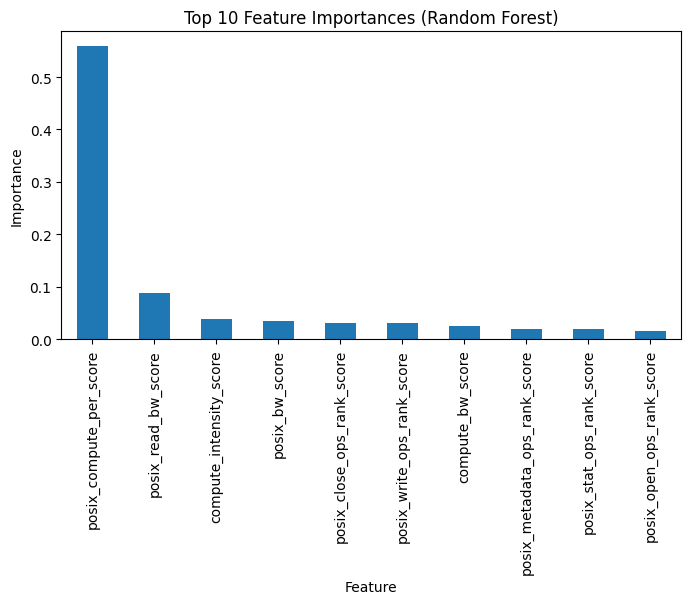

time: 313 ms (started: 2024-12-08 18:56:21 -08:00)


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting data into features (X) and target (y)
# df = df.dropna()
df = pd.read_csv('cosmoflow_node4_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top features
print("Feature Importances (Random Forest):")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


Top correlations with 'dlio_compute_util_score':
dlio_compute_util_score               1.000000
posix_time_norm_score                 0.440294
posix_ops_rank_score                  0.405645
posix_read_ops_rank_score             0.386013
posix_compute_per_score               0.347691
                                        ...   
u_reader_preprocess_time_per_score         NaN
u_reader_sample_time_norm_score            NaN
u_reader_sample_time_per_score             NaN
u_reader_time_norm_score                   NaN
u_reader_time_per_score                    NaN
Name: dlio_compute_util_score, Length: 146, dtype: float64


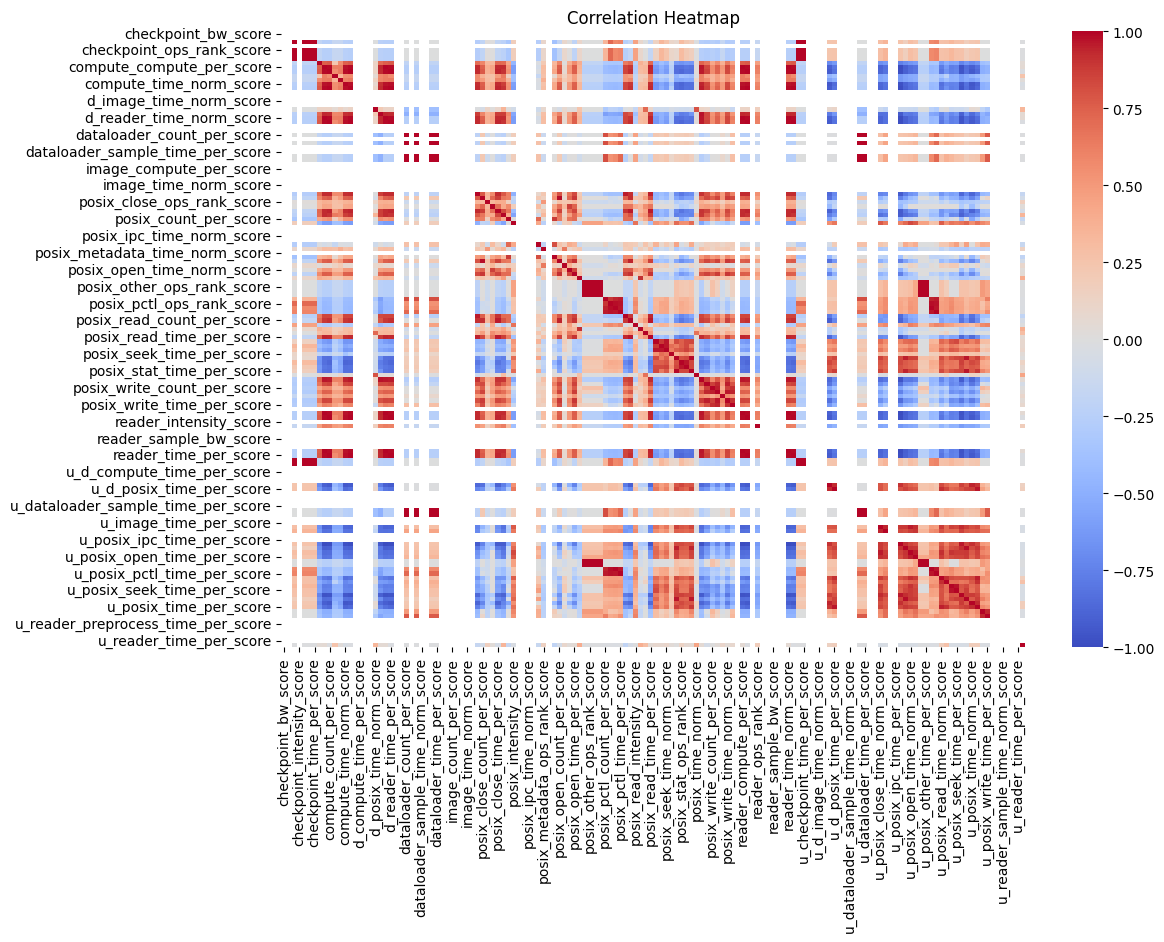

time: 822 ms (started: 2024-12-08 18:56:15 -08:00)


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your dataframe containing the scores

df = pd.read_csv('cosmoflow_node4_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target]


# df = norm_scores.copy()

# Calculate correlation matrix
correlation_matrix = df[score_cols].copy().corr()

# Focus on correlations with 'dlio_compute_util_score'
target_correlation = correlation_matrix[target].sort_values(ascending=False)

# Print correlations
print("Top correlations with 'dlio_compute_util_score':")
print(target_correlation)

# Plot a heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Optional: Heatmap focusing only on top 10 correlated features
# top_features = target_correlation.index[:10]  # Top 10 features
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0, cbar=True)
# plt.title('Heatmap of Top 10 Correlated Features with dlio_compute_util_score')
# plt.show()


In [60]:
import pandas as pd

norm_scores_all = norm_scores.copy()
for col in norm_cols:
    norm_scores2 = norm_scores.copy()
    norm_scores2['score_col'] = col
    norm_scores2['score'] = norm_scores2[col]
    norm_scores_all = pd.concat([norm_scores_all, norm_scores2])
norm_scores_all.drop(columns=norm_cols).dropna()

,score_col,score
time_range,,
82,dlio_compute_util_score,3
83,dlio_compute_util_score,0
84,dlio_compute_util_score,0
85,dlio_compute_util_score,0
86,dlio_compute_util_score,0
...,...,...
389,u_reader_time_norm_score,0
390,u_reader_time_norm_score,0
391,u_reader_time_norm_score,0


In [61]:
from math import pi

import pandas as pd

from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn, Reds, TolYlOrBr
from bokeh.io import output_notebook

output_notebook()


VAL_COL = 'proc_id'

years = list(time_range_view.index.astype(str))
months = list(reversed(norm_cols))

# reshape to 1D array or rates with a month and year for each row.
df = norm_scores_all.drop(
    columns=norm_cols
).reset_index().dropna()  # pd.DataFrame(data.stack(), columns=['rate']).reset_index()

# this is the colormap from the original NYTimes plot
colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]
mapper = linear_cmap(
    field_name="score",
    palette=Reds[8][::-1],  # Green-to-Red palette with 11 steps
    low=0,
    high=8,
)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(
    # title=f"US Unemployment ({years[0]} - {years[-1]})",
    x_range=years,
    y_range=months,
    x_axis_location="above",
    width=900,
    height=400,
    tools=TOOLS,
    toolbar_location='below',
    tooltips=[('date', '@time_range'), ('score', '@score%')],
)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

r = p.rect(
    x="time_range",
    y="score_col",
    width=1,
    height=1,
    source=df,
    fill_color=mapper, # linear_cmap("score", colors, low=0, high=8),
    line_color=None,
)

p.add_layout(
    r.construct_color_bar(
        major_label_text_font_size="7px",
        ticker=BasicTicker(desired_num_ticks=len(colors)),
        formatter=PrintfTickFormatter(format="%d%%"),
        label_standoff=6,
        border_line_color=None,
        padding=5,
    ),
    'right',
)

show(p)

Loading BokehJS ...

In [49]:
flat_views[('proc_name', 'host_name')].sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='bar', stacked=True)

NameError: name 'flat_views' is not defined

<Axes: xlabel='host_name'>

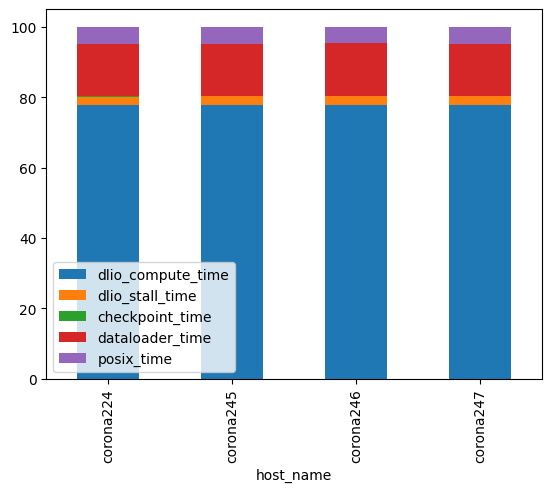

time: 196 ms (started: 2024-12-02 01:21:02 -08:00)


In [17]:
# Select the relevant columns
columns = [
    'dlio_compute_time',
    'dlio_stall_time',
    'checkpoint_time',
    'dataloader_time',
    'posix_time',
]

# Get the data and normalize to percentages
data = flat_views[('proc_name', 'host_name')].sort_index()[columns]
data_percentage = data.div(data.sum(axis=1), axis=0) * 100

# Plot the data as a stacked bar chart
data_percentage.plot(kind='bar', stacked=True)


<Axes: >

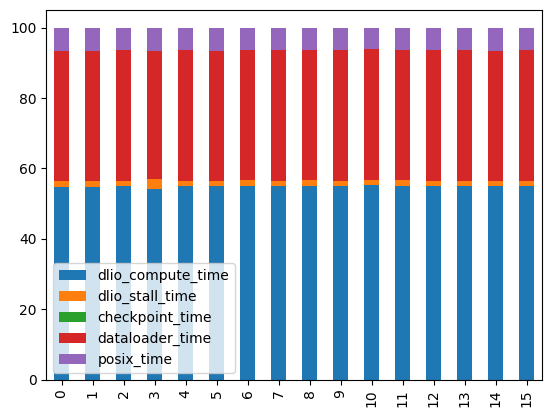

time: 336 ms (started: 2024-12-02 01:21:43 -08:00)


In [19]:
import pandas as pd

df2 = pd.read_csv('cosmoflow_node16_host_name.csv')

# Select the relevant columns
columns = [
    'dlio_compute_time',
    'dlio_stall_time',
    'checkpoint_time',
    'dataloader_time',
    'posix_time',
]

# Get the data and normalize to percentages
data = df2.sort_index()[columns]
data_percentage = data.div(data.sum(axis=1), axis=0) * 100

# Plot the data as a stacked bar chart
data_percentage.plot(kind='bar', stacked=True)


In [1]:
import pandas as pd



<Axes: >

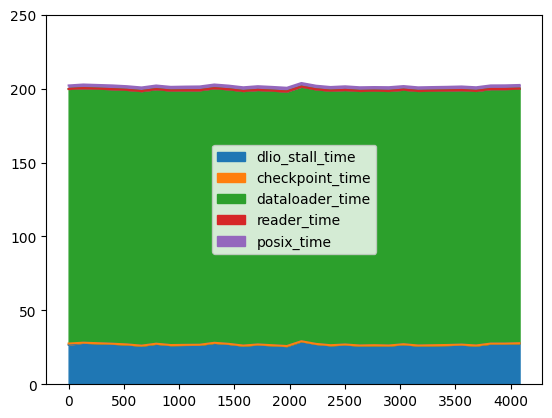

In [4]:
pd.read_csv('cosmoflow_node4_proc_name.csv').query('compute_time > 0').sort_index()[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'reader_time',
        # 'dataloader_sample_time',
        'posix_time',
    ]
].plot(kind='area', ylim=(0, 250))

<Axes: xlabel='time_range'>

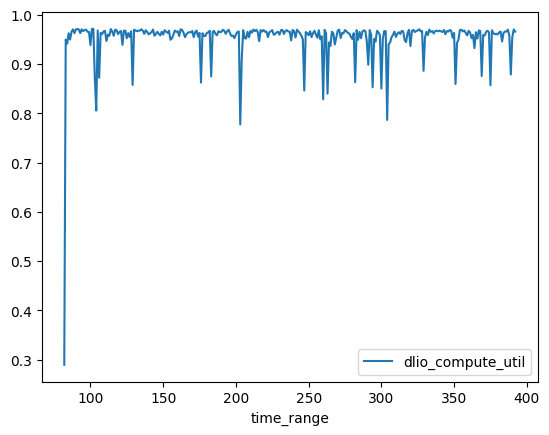

time: 166 ms (started: 2024-12-04 23:17:26 -08:00)


In [20]:
pd.read_csv('cosmoflow_node4_time_range.csv').set_index('time_range')[
    [
        # 'compute_time',
        # 'checkpoint_time',
        'dlio_compute_util',
        # 'dlio_stall_time',
        # 'dataloader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'u_dataloader_sample_time',
        # 'u_posix_time',
    ]
].plot()

<Axes: xlabel='time_range'>

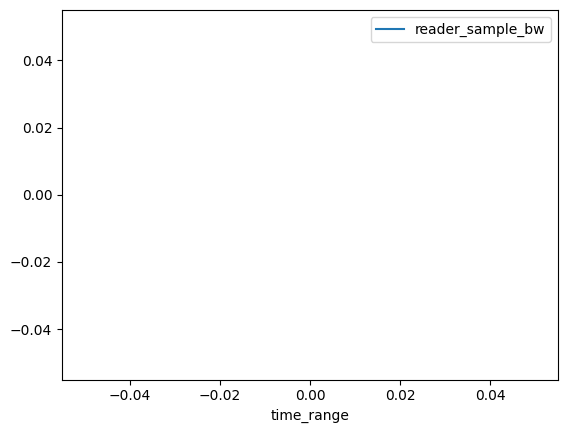

In [3]:
import pandas as pd
pd.read_csv('cosmoflow_node4_time_range.csv').set_index('time_range')[
    [
        # 'compute_time',
        # 'checkpoint_time',
        'reader_sample_bw',
        # 'dlio_stall_time',
        # 'dataloader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'u_dataloader_sample_time',
        # 'u_posix_time',
    ]
].plot()

In [ ]:
 App Time  Runtime: 1179.61 seconds (100%)                                                                      │
│            ├── Application I/O Time: 0.00 seconds (0.00%)                                                       │
│            ├── Checkpoint I/O Time: 0.00 seconds (0.00%)                                                        │
│            ├── Compute Time: 776.24 seconds (65.80%)                                                            │
│            ├── I/O Time: 351.43 seconds (29.79%)                                                                │
│            ├── Read I/O Time: 0.00 seconds (0.00%)                                                              │
│            ├── Time: 2058.26 seconds (174.49%)                                                                  │
│            ├── Unoverlapped Application I/O Time: 0.00 seconds (0.00%)                                          │
│            ├── Unoverlapped Checkpoint I/O Time: 0.00 seconds (0.00%)                                           │
│            ├── Unoverlapped Compute Time: 428.10 seconds (36.29%)                                               │
│            ├── Unoverlapped I/O Time: 3.30 seconds (0.28%)                                                      │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 776.24 seconds (65.80%)          

In [11]:
main_views['APP'].query('stall_time > 0.5').compute()

time  count  size_min  \
proc_name                     time_range step                               
app#corona246#863295#863295   82         1       0.76555     37       324   
app#corona246#863297#863297   203        16383  5.087053    832     31100   
app#corona224#1481568#1481568 203        16383  4.990194    829     31100   
app#corona247#336892#336892   82         1      0.757585     39       324   
app#corona245#652155#652155   260        16383  5.052224    872     28578   
app#corona247#336893#336893   104        5611   0.659715      4     11222   
                              82         1      0.753441     39       324   
app#corona224#1481569#1481569 263        16383   5.13534    908     30102   
app#corona247#336888#336888   294        16383  5.063508    876     13552   
app#corona224#1481571#1481571 82         1      0.764139     37       324   
app#corona246#863297#863297   82         1      0.753382     37       324   
app#corona245#652152#652152   304        16383   4.40237    600     18706   
app#corona224#1481570#1481570 82         1      0.764383     37       324   
app#corona247#336887#336887   82         1      0.768604     37       324   
app#corona247#336888#336888   82         1      0.764989     37       324   
app#corona247#336890#336890   300        16383   5.15886    920     16626   
app#corona245#652151#652151   82         1      0.754616     37       324   
app#corona245#652154#652154   82         1      0.766251     37       324   
app#corona245#652155#652155   82         1      0.765667     37       324   
app#corona246#863298#863298   82         1       0.76888     37       324   
app#corona247#336891#336891   82         1       0.75337     37       324   
app#corona224#1481573#1481573 82         1       0.76708     37       324   
app#corona246#863292#863292   351        16383  5.576807    985     10828   
app#corona246#863293#863293   82         1      0.765257     37       324   
app#corona224#1481572#1481572 82         1      0.753064     37       324   
app#corona224#1481569#1481569 82         1      0.758143     37       324   
app#corona245#652157#652157   82         1      0.766134     37       324   
app#corona246#863291#863291   82         1      0.754179     37       324   
app#corona247#336890#336890   82         1      0.754171     39       324   
app#corona246#863294#863294   82         1      0.769801     37       324   
app#corona247#336892#336892   203        16383  5.067013    829     31100   
app#corona245#652150#652150   82         1      0.754439     37       324   
app#corona245#652152#652152   82         1      0.757733     37       324   
app#corona245#652153#652153   82         1      0.754271     37       324   
app#corona247#336893#336893   247        16383  5.131979    912     21702   
app#corona247#336886#336886   82         1      0.765172     37       324   
app#corona224#1481570#1481570 203        16383  5.083132    832     31100   
app#corona224#1481574#1481574 82         1      0.753145     37       324   
app#corona246#863296#863296   82         1      0.765041     39       324   
app#corona246#863291#863291   304        16383  4.403486    600     18706   
app#corona246#863292#863292   82         1       0.75394     37       324   
app#corona247#336889#336889   82         1      0.753351     37       324   
app#corona224#1481573#1481573 203        16383   5.08433    832     31100   
app#corona224#1481572#1481572 104        5611   0.659719      4     11222   
app#corona224#1481568#1481568 82         1      0.764159     37       324   
app#corona247#336893#336893   203        16383  5.086856    832     31100   
app#corona246#863298#863298   203        16383  4.925744    829     31100   
app#corona245#652156#652156   82         1      0.769815     39       324   
app#corona224#1481567#1481567 82         1      0.753428     41       484   

                                                size_max     size  \
proc_name                     time_range step          

time: 148 ms (started: 2024-11-30 14:34:03 -08:00)


In [12]:
len(traces), len(hlms['APP']), len(main_views['APP']), len(flat_views[('proc_name',)])

(69128031, 6011276, 3110459, 4032)

time: 37.7 s (started: 2024-11-30 14:34:12 -08:00)


In [13]:
len(traces), len(hlms['APP']), len(main_views['APP']), len(flat_views[('proc_name',)])

(69128031, 6011276, 3110459, 4032)

time: 37.1 s (started: 2024-11-30 13:17:32 -08:00)


In [16]:
traces.query('func_id.str.contains("checkpoint")').compute()

,cat,time,epoch,level,func_id,pid,step,te,tid,time_range,...,checkpoint_time,read_time,hash,value,file_name,host_name,acc_pat,count,proc_name,batch


time: 37.2 s (started: 2024-11-30 14:36:42 -08:00)


In [ ]:
flat_views[('proc_name', 'proc_id')].compute()

,app_bw,app_checkpoint_time,app_checkpoint_time_per,app_compute_time,app_compute_time_per,app_count,app_count_per,app_intensity,app_intensity_rank,app_ops,...,u_posix_ipc_time,u_posix_metadata_time,u_posix_open_time,u_posix_other_time,u_posix_pctl_time,u_posix_read_time,u_posix_seek_time,u_posix_stat_time,u_posix_time,u_posix_write_time
proc_id,,,,,,,,,,,,,,,,,,,,,
1481567,124501243.79336,0.0,NaN,773.721859,0.031244,1567923,0.031264,0.000007,1.00000,838.254837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481568,124552422.901563,0.0,NaN,773.883129,0.03125,1567046,0.031246,0.000007,0.53125,838.142801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481569,124579168.744387,0.0,NaN,773.931963,0.031252,1567336,0.031252,0.000007,0.43750,838.299262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481570,124563510.41499,0.0,NaN,773.863321,0.031249,1567563,0.031257,0.000007,0.93750,838.358958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481571,124568691.858858,0.0,NaN,773.895916,0.031251,1567180,0.031249,0.000007,0.15625,838.160135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481572,124616912.858316,0.0,NaN,773.608404,0.031239,1567148,0.031248,0.000007,0.09375,838.480831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481573,124601841.084558,0.0,NaN,773.92247,0.031252,1567208,0.031250,0.000007,0.03125,838.272549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1481574,124561947.492844,0.0,NaN,773.842234,0.031249,1567233,0.031250,0.000007,0.87500,838.316209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
652150,124494322.607033,0.0,NaN,773.870951,0.03125,1566987,0.031245,0.000007,0.90625,837.861789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 4.03 s (started: 2024-11-30 14:35:59 -08:00)


In [12]:
flat_views[('step',)].compute().sort_index()

,app_bw,app_checkpoint_time,app_checkpoint_time_per,app_compute_time,app_compute_time_per,app_count,app_count_per,app_intensity,app_intensity_rank,app_ops,...,u_posix_ipc_time,u_posix_metadata_time,u_posix_open_time,u_posix_other_time,u_posix_pctl_time,u_posix_read_time,u_posix_seek_time,u_posix_stat_time,u_posix_time,u_posix_write_time
step,,,,,,,,,,,,,,,,,,,,,
1,9306230.575615,0.0,NaN,0.009457,0.000012,9438,0.000188,0.000006,0.065067,54.59634,...,0.0,0.009336,0.004524,0.0,0.0,0.243549,0.0,0.0,0.256696,0.0
2,383636657.523511,0.0,NaN,0.009442,0.000012,229,0.000005,0.000019,0.993103,7477.795193,...,0.0,0.000000,0.000000,0.0,0.0,0.018132,0.0,0.0,0.018132,0.0
3,213974324.838342,0.0,NaN,0.009437,0.000012,191,0.000004,0.000034,0.996277,7265.119817,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,731796715.733625,0.0,NaN,0.009449,0.000012,548,0.000011,0.000011,0.974181,7900.693473,...,0.0,0.000000,0.000000,0.0,0.0,0.058252,0.0,0.0,0.059912,0.0
5,100521810.942339,0.0,NaN,0.009437,0.000012,173,0.000003,0.000051,0.997314,5102.492258,...,0.0,0.000000,0.000000,0.0,0.0,0.024468,0.0,0.0,0.024468,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,53734672.954685,0.0,NaN,0.009442,0.000012,160,0.000003,0.000153,0.998718,8201.763379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16380,51446238.406046,0.0,NaN,0.009441,0.000012,160,0.000003,0.000153,0.998657,7851.989989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16381,52285871.028876,0.0,NaN,0.009446,0.000012,160,0.000003,0.000153,0.998596,7979.651888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 7.59 s (started: 2024-11-30 13:16:33 -08:00)


In [15]:
flat_views[('time_range',)].compute().sort_index()

,app_bw,app_checkpoint_time,app_checkpoint_time_per,app_compute_time,app_compute_time_per,app_count,app_count_per,app_intensity,app_intensity_rank,app_ops,...,u_posix_ipc_time,u_posix_metadata_time,u_posix_open_time,u_posix_other_time,u_posix_pctl_time,u_posix_read_time,u_posix_seek_time,u_posix_stat_time,u_posix_time,u_posix_write_time
time_range,,,,,,,,,,,,,,,,,,,,,
25,0.0,0.0,NaN,0.0,0.0,32,6.380678e-07,0.000000,0.004792,0.185922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,0.0,0.0,NaN,0.0,0.0,32,6.380678e-07,0.000000,0.004792,680851.06383,...,0.0,0.000047,0.0,0.0,0.0,0.000000,0.0,0.0,0.000047,0.0
82,2203903273.225718,0.0,NaN,0.13223,0.00017,15010,2.992937e-04,0.000007,0.009585,14327.700571,...,0.0,0.000000,0.0,0.0,0.0,0.217991,0.0,0.0,0.226705,0.0
83,4196489958.846256,0.0,NaN,2.338899,0.003013,151460,3.020055e-03,0.000007,0.881789,28373.752724,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
84,4283314481.913196,0.0,NaN,2.398264,0.00309,155777,3.106134e-03,0.000007,0.869010,28951.114271,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,4408225391.916886,0.0,NaN,2.505405,0.003228,161974,3.229700e-03,0.000007,0.086262,29519.220553,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
389,4020298497.136328,0.0,NaN,2.178422,0.002806,141513,2.821715e-03,0.000007,0.028754,26853.550207,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
390,4412788175.716153,0.0,NaN,2.494512,0.003214,159912,3.188585e-03,0.000007,0.252396,29612.560116,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


time: 1.31 s (started: 2024-11-30 00:06:30 -08:00)


In [16]:
flat_views[('proc_name',)].compute().sort_index()

,app_bw,app_checkpoint_time,app_checkpoint_time_per,app_compute_time,app_compute_time_per,app_count,app_count_per,app_intensity,app_intensity_rank,app_ops,...,u_posix_ipc_time,u_posix_metadata_time,u_posix_open_time,u_posix_other_time,u_posix_pctl_time,u_posix_read_time,u_posix_seek_time,u_posix_stat_time,u_posix_time,u_posix_write_time
proc_name,,,,,,,,,,,,,,,,,,,,,
app#corona224#1481567#1481567,717758.429184,0.0,NaN,773.721859,0.031244,328666,0.006553,0.000245,1.000000,175.713899,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
app#corona224#1481567#1481950,0.0,0.0,NaN,0.0,0.0,2682,0.000053,0.000000,0.119668,1127.545491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
app#corona224#1481567#1481958,0.0,0.0,NaN,0.0,0.0,2620,0.000052,0.000000,0.119668,1135.389573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
app#corona224#1481567#1481966,0.0,0.0,NaN,0.0,0.0,2760,0.000055,0.000000,0.119668,1131.128534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
app#corona224#1481567#1481974,0.0,0.0,NaN,0.0,0.0,2790,0.000056,0.000000,0.119668,1130.178313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
app#corona247#336893#338315,51779140.304285,0.0,NaN,0.0,0.0,12869,0.000257,0.000005,0.918403,259.051812,...,0.0,1.981671,1.743684,0.0,0.0,47.695650,0.0,0.0,49.677321,0.0
app#corona247#336893#338323,49340443.005223,0.0,NaN,0.0,0.0,12832,0.000256,0.000005,0.289931,246.381327,...,0.0,2.123025,1.879381,0.0,0.0,49.958844,0.0,0.0,52.081869,0.0
app#corona247#336893#338332,48956414.89674,0.0,NaN,0.0,0.0,12859,0.000256,0.000005,0.953373,244.986857,...,0.0,2.237094,1.959864,0.0,0.0,50.251436,0.0,0.0,52.488530,0.0


time: 547 ms (started: 2024-11-30 00:06:36 -08:00)


In [12]:
from dask import persist
from dask.distributed import wait

traces_persisted = traces.persist()
wait(traces_persisted)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.core.frame.DataFrame, key: ('_set_steps-d9e76e7c69b3772bc6eecd76da84d985', 133)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('_set_steps-d9e76e7c69b3772bc6eecd76da84d985', 54)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('_set_steps-d9e76e7c69b3772bc6eecd76da84d985', 117)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('_set_steps-d9e76e7c69b3772bc6eecd76da84d985', 78)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('_set_steps-d9e76e7c69b3772bc6eecd76da84d985', 10)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('_set_steps-d9e76e7c69b3772bc6eecd76da84d985', 135)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('_set_steps-d9e76e7c69b3772bc6eecd76da84d985', 38)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('_set_steps-d9e76e7c69b3772bc6eecd76da84d985', 108)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('_se

time: 31 s (started: 2024-11-30 00:04:54 -08:00)


In [13]:
len(traces_persisted)

69128031

time: 97.9 ms (started: 2024-11-30 00:05:25 -08:00)


In [28]:
len(traces_persisted)

69128031

time: 111 ms (started: 2024-11-29 23:56:16 -08:00)


In [18]:
traces_persisted['epoch'].value_counts().compute()

epoch
0    5243292
Name: count, dtype: int64[pyarrow]

time: 158 ms (started: 2024-11-29 23:14:06 -08:00)


In [19]:
traces_persisted['step'].value_counts().compute()

step
16383    40127808
1            9438
2740         3119
4840         3063
1138         2746
           ...   
16378         160
16379         160
16380         160
16381         160
16382         128
Name: count, Length: 16383, dtype: int64[pyarrow]

time: 828 ms (started: 2024-11-29 23:14:08 -08:00)


In [20]:
traces_persisted['batch'].value_counts().compute()

batch
1.0      32768
18.0     32768
2.0      32768
31.0     32768
30.0     32768
         ...  
69.0     32767
68.0     32767
67.0     32767
66.0     32767
160.0    32765
Name: count, Length: 160, dtype: int64

time: 137 ms (started: 2024-11-29 23:14:12 -08:00)


In [11]:
traces.query('step > 0')['func_id'].value_counts().compute()

func_id
TFReader._parse_image    2621445
<module>.iter            2621280
<module>.yield           2621278
TFReader.next                 32
Name: count, dtype: int64[pyarrow]

time: 14.8 s (started: 2024-11-29 09:12:32 -08:00)


In [16]:
traces.query('func_id == "TFReader._parse_image"')['step'].value_counts().compute()

step
1    2621445
Name: count, dtype: int64[pyarrow]

time: 13.3 s (started: 2024-11-29 11:35:32 -08:00)


In [17]:
traces.query('func_id == "<module>.iter"')['step'].value_counts().compute()

step
1        160
2        160
3        160
4        160
5        160
        ... 
16379    160
16380    160
16381    160
16382    160
16383    160
Name: count, Length: 16383, dtype: int64[pyarrow]

time: 13 s (started: 2024-11-29 11:35:45 -08:00)


In [18]:
traces.query('func_id == "<module>.yield"')['step'].value_counts().compute()

step
1        160
2        160
3        160
4        160
5        160
        ... 
16381    160
16382    160
16383    160
4750     159
10754    159
Name: count, Length: 16383, dtype: int64[pyarrow]

time: 13.4 s (started: 2024-11-29 11:35:58 -08:00)


In [14]:
iter_funcs = traces.query('func_id.isin(["<module>.iter", "<module>.yield"])').compute()
iter_funcs.head()

,cat,time,epoch,level,func_id,pid,step,te,tid,time_range,...,compute_time,checkpoint_time,read_time,hash,value,file_name,host_name,acc_pat,count,proc_name
3,dlio_benchmark,0.000224,<NA>,8,<module>.iter,336892,4751,487628155,336892,162,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
4,dlio_benchmark,0.010427,<NA>,8,<module>.yield,336892,4751,487638587,336892,162,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
8,dlio_benchmark,0.000267,<NA>,8,<module>.iter,336892,4752,487638894,336892,162,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
9,dlio_benchmark,0.01021,<NA>,8,<module>.yield,336892,4752,487649109,336892,162,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
13,dlio_benchmark,0.000235,<NA>,8,<module>.iter,336892,4753,487649387,336892,162,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892


time: 18.6 s (started: 2024-11-29 13:27:29 -08:00)


In [15]:
iter_funcs['step'].value_counts()

step
4751     320
4752     320
4753     320
4754     320
4755     320
        ... 
4747     320
4748     320
4749     320
10754    319
4750     319
Name: count, Length: 16383, dtype: int64[pyarrow]

time: 31.3 ms (started: 2024-11-29 13:28:16 -08:00)


In [16]:
# Sort the trace by timestamp within each step
sorted_traces = iter_funcs.sort_values('ts')

# Create a batch grouping based on consistent batch size
sorted_traces['batch_id'] = sorted_traces.groupby(['step']).cumcount() + 1
sorted_traces

,cat,time,epoch,level,func_id,pid,step,te,tid,time_range,...,checkpoint_time,read_time,hash,value,file_name,host_name,acc_pat,count,proc_name,batch_id
3544,dlio_benchmark,0.656321,<NA>,8,<module>.iter,652150,1,248765836,652150,82,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona245,0,1,app#corona245#652150#652150,1
9145,dlio_benchmark,0.636186,<NA>,8,<module>.iter,652155,1,248745744,652155,82,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona245,0,1,app#corona245#652155#652155,2
14071,dlio_benchmark,0.713149,<NA>,8,<module>.iter,652151,1,248822714,652151,82,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona245,0,1,app#corona245#652151#652151,3
14178,dlio_benchmark,0.647458,<NA>,8,<module>.iter,863298,1,248757073,863298,82,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona246,0,1,app#corona246#863298#863298,4
8345,dlio_benchmark,0.654768,<NA>,8,<module>.iter,652156,1,248764431,652156,82,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona245,0,1,app#corona245#652156#652156,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14156,dlio_benchmark,0.011468,<NA>,8,<module>.yield,1481570,16383,1177727228,1481570,392,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona224,0,1,app#corona224#1481570#1481570,316
8759,dlio_benchmark,0.011451,<NA>,8,<module>.yield,863291,16383,1177727225,863291,392,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona246,0,1,app#corona246#863291#863291,317
5889,dlio_benchmark,0.011453,<NA>,8,<module>.yield,863294,16383,1177727233,863294,392,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona246,0,1,app#corona246#863294#863294,318
1624,dlio_benchmark,0.011451,<NA>,8,<module>.yield,863292,16383,1177727232,863292,392,...,<NA>,<NA>,<NA>,<NA>,<NA>,corona246,0,1,app#corona246#863292#863292,319


time: 5.36 s (started: 2024-11-29 13:29:00 -08:00)


In [17]:
sorted_traces.groupby(['step'])['batch_id'].count()

step
1        320
2        320
3        320
4        320
5        320
        ... 
16379    320
16380    320
16381    320
16382    320
16383    320
Name: batch_id, Length: 16383, dtype: int64

time: 111 ms (started: 2024-11-29 13:30:45 -08:00)


In [18]:
sorted_traces.groupby(['batch_id', 'step']).agg({'ts':min,'te':max}).query('step == 1')

,,ts,te
batch_id,step,,
1,1,248109515,248765836
2,1,248109558,248745744
3,1,248109565,248822714
4,1,248109615,248757073
5,1,248109663,248764431
...,...,...,...
316,1,992834792,992847832
317,1,992835467,992847831
318,1,992836022,992847841


time: 2.54 s (started: 2024-11-29 13:30:49 -08:00)


In [ ]:
traces.query('ts > 619761989 and te < 619780997').compute().to_csv('step1_batch2.csv')

time: 16.4 s (started: 2024-11-29 12:52:37 -08:00)


In [13]:
traces.query('func_id.str.contains("compute") and pid == 336892').compute()

,cat,time,epoch,level,func_id,pid,step,te,tid,time_range,...,compute_time,checkpoint_time,read_time,hash,value,file_name,host_name,acc_pat,count,proc_name
2,ai_framework,0.009432,0,8,TFFramework.compute,336892,<NA>,487637732,336892,162,...,0.009432,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
7,ai_framework,0.009426,0,8,TFFramework.compute,336892,<NA>,487648469,336892,162,...,0.009426,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
12,ai_framework,0.009429,0,8,TFFramework.compute,336892,<NA>,487658954,336892,162,...,0.009429,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
17,ai_framework,0.00948,0,8,TFFramework.compute,336892,<NA>,487670236,336892,162,...,0.00948,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
22,ai_framework,0.009426,0,8,TFFramework.compute,336892,<NA>,487680913,336892,162,...,0.009426,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,ai_framework,0.009431,0,8,TFFramework.compute,336892,<NA>,487582975,336892,162,...,0.009431,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
5108,ai_framework,0.009433,0,8,TFFramework.compute,336892,<NA>,487593481,336892,162,...,0.009433,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
5113,ai_framework,0.009429,0,8,TFFramework.compute,336892,<NA>,487604794,336892,162,...,0.009429,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892
5118,ai_framework,0.009438,0,8,TFFramework.compute,336892,<NA>,487615691,336892,162,...,0.009438,<NA>,<NA>,<NA>,<NA>,<NA>,corona247,0,1,app#corona247#336892#336892


time: 15.9 s (started: 2024-11-29 12:58:36 -08:00)


In [55]:
batch_idx = batch_ids.to_frame().reset_index()
batch_idx

,index,0
0,3544,0
1,9145,1
2,14071,2
3,14178,3
4,8345,4
...,...,...
2621275,13972,155
2621276,1623,156
2621277,8758,157
2621278,5888,158


time: 13.4 ms (started: 2024-11-29 12:11:23 -08:00)


In [56]:
batch_idx[batch_idx['index'] == 100]

,index,0
29004,100,12
29436,100,28
63596,100,12
82382,100,14
82832,100,16
...,...,...
2563686,100,134
2565834,100,138
2584213,100,149
2602260,100,148


time: 7.5 ms (started: 2024-11-29 12:11:33 -08:00)


In [36]:
sorted_traces.head()

,cat,time,epoch,level,func_id,pid,step,te,tid,time_range,...,size,compute_time,checkpoint_time,read_time,hash,value,acc_pat,count,proc_name,batch_id
9029,dlio_benchmark,0.019008,0,8,<module>.iter,336892,1,619780997,336892,206,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,1,app#corona247#336892#336892,0
9035,dlio_benchmark,0.020989,0,8,<module>.iter,336892,1,804853856,336892,268,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,1,app#corona247#336892#336892,0
9041,dlio_benchmark,0.016597,0,8,<module>.iter,336892,1,992819364,336892,330,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,1,app#corona247#336892#336892,0
9081,dlio_benchmark,0.670782,0,8,<module>.iter,336891,1,248780970,336891,82,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,1,app#corona247#336891#336891,0
9087,dlio_benchmark,0.027247,0,8,<module>.iter,336891,1,434713510,336891,144,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,1,app#corona247#336891#336891,0


time: 16.8 ms (started: 2024-11-29 11:53:41 -08:00)


In [37]:
sorted_traces['batch_id'].value_counts()

batch_id
0    2621280
Name: count, dtype: int64

time: 13.4 ms (started: 2024-11-29 11:53:41 -08:00)


In [15]:
traces.query('func_id == "<module>.iter" and step > 100 and step < 102').groupby(
    ['pid', 'tid', 'step']
).agg({'ts': 'min', 'te': 'max'}).compute().reset_index().sort_values('step')

,pid,tid,step,ts,te
0,336892,336892,101,250063921,993946185
1,336891,336891,101,250063926,993946183
2,652155,652155,101,250063917,993946430
3,336893,336893,101,250063919,993946180
4,336887,336887,101,250063923,993946180
5,336886,336886,101,250063920,993946188
6,336889,336889,101,250063921,993946185
7,336890,336890,101,250063914,993946187
8,863296,863296,101,250063909,993946775
9,863294,863294,101,250063909,993946212


time: 13.7 s (started: 2024-11-29 10:06:33 -08:00)


In [13]:
traces.query('func_id == "<module>.iter"').compute().to_csv('iter.csv')

time: 36.5 s (started: 2024-11-29 09:52:55 -08:00)


In [10]:
metric_cols = [
    col for col in flat_views[('time_range',)].columns if col.startswith("m_")
]

time: 805 µs (started: 2024-11-29 08:41:31 -08:00)


In [11]:
tr_view = flat_views[('time_range',)].compute()
tr_view

,app_bw,app_checkpoint_time,app_checkpoint_time_per,app_compute_time,app_compute_time_per,app_count,app_count_per,app_intensity,app_intensity_rank,app_ops,...,u_posix_ipc_time,u_posix_metadata_time,u_posix_open_time,u_posix_other_time,u_posix_pctl_time,u_posix_read_time,u_posix_seek_time,u_posix_stat_time,u_posix_time,u_posix_write_time
time_range,,,,,,,,,,,,,,,,,,,,,
0,24018639.223063,0.0,0.0,0.0,0.0,306362,0.004432,0.072484,0.982090,1740960.260949,...,0.0,0.166246,0.007740,0.000000,0.0,0.019144,0.000038,0.108811,0.175973,0.000000
1,1111480.371218,0.0,0.0,0.0,0.0,58931,0.000853,0.507794,0.991045,564402.900022,...,0.0,0.104200,0.068501,0.000131,0.0,0.001765,0.000000,0.021113,0.104413,0.000107
2,4113184.951513,0.0,0.0,0.0,0.0,21101,0.000305,0.149845,0.988060,616339.525646,...,0.0,0.031520,0.025483,0.000000,0.0,0.003007,0.000000,0.002300,0.034236,0.000098
7,0.0,0.0,0.0,0.0,0.0,11424,0.000165,0.000000,0.020896,472241.742797,...,0.0,0.024191,0.000000,0.000000,0.0,0.000000,0.000000,0.010574,0.024191,0.000000
8,425070997.646976,0.0,0.0,0.0,0.0,123432,0.001786,0.001284,0.970149,545937.052173,...,0.0,0.172176,0.074124,0.000000,0.0,0.060287,0.000088,0.057627,0.226092,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,4412788175.716153,0.0,0.0,2.494512,0.003214,159912,0.002313,0.000007,0.268657,29612.560116,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
391,4504606549.36867,0.0,0.0,2.562258,0.003301,166767,0.002412,0.000007,0.056716,30084.024639,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
392,4316909204.549961,0.00001,0.000012,1.439789,0.001855,104776,0.001516,0.000007,0.967164,31960.759791,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


time: 677 ms (started: 2024-11-29 08:41:32 -08:00)


In [12]:
import numpy as np
tr_view['posix_u_time'] = np.maximum(tr_view['posix_time'] - tr_view['app_compute_time'], 0)
tr_view[['posix_u_time']]

,posix_u_time
time_range,
0,0.175973
1,0.104413
2,0.034236
7,0.024191
8,0.226092
...,...
390,0.000000
391,0.000000
392,0.000000


time: 6.8 ms (started: 2024-11-28 12:30:57 -08:00)


In [27]:
tr_view.columns[tr_view.columns.str.contains('_time') & ~tr_view.columns.str.contains('m_')]

Index(['app_checkpoint_time', 'app_compute_time', 'app_read_time', 'app_time',
       'app_u_checkpoint_time', 'app_u_compute_time', 'app_u_read_time',
       'dataloader_time', 'posix_close_time', 'posix_data_time',
       'posix_ipc_time', 'posix_metadata_time', 'posix_open_time',
       'posix_other_time', 'posix_pctl_time', 'posix_read_time',
       'posix_seek_time', 'posix_stat_time', 'posix_time', 'posix_write_time',
       'posix_u_time'],
      dtype='object')

time: 3.02 ms (started: 2024-11-28 12:12:42 -08:00)


In [32]:
def _find_metric(metrics, suffix):
    return [m for m in metrics if m.endswith(suffix)]

any(_find_metric(tr_view.columns, '_cmpute_time'))

False

time: 2.46 ms (started: 2024-11-28 12:19:20 -08:00)


In [34]:
if ['']: 
    print("LOL") 

LOL
time: 694 µs (started: 2024-11-28 12:20:20 -08:00)


In [23]:
tr_view.sum()[
    [
        'app_checkpoint_time',
        'app_compute_time',
        'app_read_time',
        'app_time',
        'dataloader_time',
        'posix_time',
        'app_u_checkpoint_time',
        'app_u_read_time',
        'posix_u_time',
    ]
]

app_checkpoint_time         0.865758
app_compute_time          776.239309
app_read_time               17.54945
app_time                 2058.255938
dataloader_time           695.752602
posix_time                351.431483
app_u_checkpoint_time       0.865748
app_u_read_time                  0.0
posix_u_time                3.296051
dtype: double[pyarrow]

time: 14.4 ms (started: 2024-11-28 12:10:44 -08:00)


In [ ]:
 App Time  Runtime: 1179.61 seconds (100%)                                                                      │
│            ├── Application I/O Time: 0.00 seconds (0.00%)                                                       │
│            ├── Checkpoint I/O Time: 0.00 seconds (0.00%)                                                        │
│            ├── Compute Time: 776.24 seconds (65.80%)                                                            │
│            ├── I/O Time: 351.43 seconds (29.79%)                                                                │
│            ├── Read I/O Time: 0.00 seconds (0.00%)                                                              │
│            ├── Time: 2058.26 seconds (174.49%)                                                                  │
│            ├── Unoverlapped Application I/O Time: 0.00 seconds (0.00%)                                          │
│            ├── Unoverlapped Checkpoint I/O Time: 0.00 seconds (0.00%)                                           │
│            ├── Unoverlapped Compute Time: 428.10 seconds (36.29%)                                               │
│            ├── Unoverlapped I/O Time: 3.30 seconds (0.28%)                                                      │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 776.24 seconds (65.80%)          

In [13]:
hlms['POSIX'].groupby(['func_id'])['io_cat'].unique().compute()

func_id
__fxstat      [3]
__fxstat64    [3]
__lxstat64    [3]
__xstat       [3]
__xstat64     [3]
access        [3]
close         [3]
fclose        [3]
fcntl         [3]
fopen         [3]
fopen64       [3]
fork          [4]
fread         [1]
fseek         [3]
ftell         [3]
fwrite        [2]
lseek64       [3]
mkdir         [3]
mmap          [6]
open          [3]
open64        [3]
opendir       [3]
pread         [1]
read          [1]
readlink      [3]
rename        [3]
rmdir         [3]
unlink        [3]
write         [2]
Name: io_cat, dtype: object

time: 139 ms (started: 2024-11-28 12:02:21 -08:00)


In [11]:
hlms['APP'].compute()

,acc_pat,cat,time_range,io_cat,func_id,proc_name,time,count,size_min,size_max,size
0,0,ai_framework,162,6,TFFramework.compute,app#corona247#336892#336892,2.600161,275,4602,4876,1303225
1,0,reader,163,6,TFReader._parse_image,app#corona247#336892#337503,0.042252,51,<NA>,<NA>,0
2,0,reader,166,6,TFReader._parse_image,app#corona247#336892#337479,0.034386,42,<NA>,<NA>,0
3,0,reader,173,6,TFReader._parse_image,app#corona247#336892#337518,0.026904,31,<NA>,<NA>,0
4,0,reader,176,6,TFReader._parse_image,app#corona247#336892#337510,0.034704,40,<NA>,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...
64991,0,reader,386,6,TFReader._parse_image,app#corona245#652152#653392,0.038129,44,<NA>,<NA>,0
64992,0,reader,386,6,TFReader._parse_image,app#corona245#652152#653376,0.030987,35,<NA>,<NA>,0
64993,0,reader,387,6,TFReader._parse_image,app#corona245#652152#653392,0.040674,45,<NA>,<NA>,0
64994,0,reader,388,6,TFReader._parse_image,app#corona245#652152#653408,0.041859,49,<NA>,<NA>,0


time: 394 ms (started: 2024-11-27 21:42:19 -08:00)


In [12]:
hlms['APP'].query('func_id.str.contains("compute")').compute()

,acc_pat,cat,time_range,io_cat,func_id,proc_name,time,count,size_min,size_max,size
0,0,ai_framework,162,6,TFFramework.compute,app#corona247#336892#336892,2.600161,275,4602,4876,1303225
24,0,ai_framework,226,6,TFFramework.compute,app#corona247#336892#336892,2.531713,268,5215,5482,1433398
61,0,ai_framework,297,6,TFFramework.compute,app#corona247#336892#336892,2.542245,269,7509,7777,2055967
84,0,ai_framework,348,6,TFFramework.compute,app#corona247#336892#336892,2.572613,272,4605,4876,1289416
113,0,ai_framework,99,6,TFFramework.compute,app#corona247#336891#336891,2.58534,274,4289,4562,1212587
...,...,...,...,...,...,...,...,...,...,...,...
64955,0,ai_framework,310,6,TFFramework.compute,app#corona245#652152#652152,2.466015,261,10817,11077,2857167
64957,0,ai_framework,316,6,TFFramework.compute,app#corona245#652152#652152,2.425587,257,12425,12681,3226121
64962,0,ai_framework,327,6,TFFramework.compute,app#corona245#652152#652152,2.537822,268,15371,15638,4155206
64966,0,ai_framework,334,6,TFFramework.compute,app#corona245#652152#652152,2.475627,262,828,1089,251127


time: 167 ms (started: 2024-11-27 21:42:32 -08:00)


In [13]:
hlms['DATALOADER'].query('func_id.str.contains(".compute|.trace_object")').compute()

,acc_pat,cat,time_range,io_cat,func_id,proc_name,time,count,size_min,size_max,size
0,0,ai_framework,162,6,TFFramework.compute,app#corona247#336892#336892,2.600161,275,4602,4876,1303225
11,0,ai_framework,190,6,TFFramework.trace_object,app#corona247#336892#336892,0.001657,272,12050,12321,3314456
24,0,ai_framework,226,6,TFFramework.compute,app#corona247#336892#336892,2.531713,268,5215,5482,1433398
27,0,ai_framework,233,6,TFFramework.trace_object,app#corona247#336892#336892,0.001648,273,7089,7361,1972425
29,0,ai_framework,234,6,TFFramework.trace_object,app#corona247#336892#336892,0.001657,274,7362,7635,2054589
...,...,...,...,...,...,...,...,...,...,...,...
64962,0,ai_framework,327,6,TFFramework.compute,app#corona245#652152#652152,2.537822,268,15371,15638,4155206
64966,0,ai_framework,334,6,TFFramework.compute,app#corona245#652152#652152,2.475627,262,828,1089,251127
64977,0,ai_framework,364,6,TFFramework.trace_object,app#corona245#652152#652152,0.001595,264,8844,9107,2369532
64978,0,ai_framework,365,6,TFFramework.trace_object,app#corona245#652152#652152,0.001648,272,9108,9379,2514232


time: 175 ms (started: 2024-11-27 21:42:43 -08:00)


In [14]:
hlms['POSIX'].compute()

,acc_pat,cat,time_range,io_cat,func_id,proc_name,time,count,size_min,size_max,size
412,0,POSIX,1,3,opendir,app#corona224#1481567#1481567,0.014718,85,<NA>,<NA>,0
413,0,STDIO,2,3,fopen,app#corona224#1481567#1481567,0.012389,46,<NA>,<NA>,0
414,0,POSIX,8,3,__xstat64,app#corona224#1481567#1481567,0.055711,3246,<NA>,<NA>,0
415,0,POSIX,11,3,open64,app#corona224#1481567#1481567,0.000849,2,<NA>,<NA>,0
416,0,POSIX,12,3,__xstat64,app#corona224#1481567#1481567,0.888854,2966,<NA>,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...
64825,0,POSIX,391,3,open,app#corona224#1481567#1482964,0.032654,15,<NA>,<NA>,0
64826,0,POSIX,391,3,close,app#corona224#1481567#1482964,0.003757,15,<NA>,<NA>,0
64827,0,POSIX,392,3,close,app#corona224#1481567#1482964,0.001774,7,<NA>,<NA>,0
64828,0,POSIX,392,3,open,app#corona224#1481567#1482997,0.022576,8,<NA>,<NA>,0


time: 324 ms (started: 2024-11-27 21:42:51 -08:00)


In [15]:
main_views['APP'].compute()

time  count  size_min  size_max  \
proc_name                     time_range                                        
app#corona224#1481567#1481567 0           0.162465   9567        24     30699   
                              1           0.068187   1833      3133      3278   
                              2           0.022109    668        26       458   
                              7           0.024191    357         0         0   
                              8           0.217051   3858       976     65536   
...                                            ...    ...       ...       ...   
app#corona247#336893#338346   388         0.794966    214      3081    262144   
                              389         0.790638    183      9305    262144   
                              390         0.874091    197     45682    262144   
                              391         0.708449    212     11540    262144   
                              392         0.448508    125    110672    262144   

                                              size  checkpoint_time  \
proc_name                     time_range                              
app#corona224#1481567#1481567 0             117749              0.0   
                              1               3531              0.0   
                              2               4519              0.0   
                              7                  0              0.0   
                              8            3003286              0.0   
...                                            ...              ...   
app#corona247#336893#338346   388         42490076              0.0   
                              389         36977643              0.0   
                              390         39098178              0.0   
                              391         42267515              0.0   
                              392         25316291              0.0   

                                          compute_time  read_time  
proc_name                     time_range                           
app#corona224#1481567#1481567 0                    0.0        0.0  
                              1                    0.0        0.0  
                              2                    0.0        0.0  
                              7                    0.0        0.0  
                              8                    0.0        0.0  
...                                                ...        ...  
app#corona247#336893#338346   388                  0.0        0.0  
                              389                  0.0        0.0  
                              390                  0.0        0.0  
                              391                  0.0        0.0  
                              392                  0.0        0.0  

[252891 rows x 8 columns]

time: 76.6 ms (started: 2024-11-27 21:42:59 -08:00)


In [16]:
main_views['DATALOADER'].compute()

time  count  size_min  size_max  \
proc_name                     time_range                                        
app#corona224#1481567#1481567 0           0.162465   9567        24     30699   
                              1           0.068187   1833      3133      3278   
                              2           0.022109    668        26       458   
                              7           0.024191    357         0         0   
                              8           0.217051   3858       976     65536   
...                                            ...    ...       ...       ...   
app#corona247#336893#338346   388         0.794966    214      3081    262144   
                              389         0.790638    183      9305    262144   
                              390         0.874091    197     45682    262144   
                              391         0.708449    212     11540    262144   
                              392         0.448508    125    110672    262144   

                                              size  image_size  \
proc_name                     time_range                         
app#corona224#1481567#1481567 0             117749           0   
                              1               3531           0   
                              2               4519           0   
                              7                  0           0   
                              8            3003286           0   
...                                            ...         ...   
app#corona247#336893#338346   388         42490076           0   
                              389         36977643           0   
                              390         39098178           0   
                              391         42267515           0   
                              392         25316291           0   

                                          image_size_max  image_size_min  
proc_name                     time_range                                  
app#corona224#1481567#1481567 0                        0               0  
                              1                        0               0  
                              2                        0               0  
                              7                        0               0  
                              8                        0               0  
...                                                  ...             ...  
app#corona247#336893#338346   388                      0               0  
                              389                      0               0  
                              390                      0               0  
                              391                      0               0  
                              392                      0               0  

[252594 rows x 8 columns]

time: 83.6 ms (started: 2024-11-27 21:43:10 -08:00)


In [17]:
main_views['DATALOADER'].query('image_size > 0').compute()

time  count  size_min  size_max  \
proc_name                     time_range                                        
app#corona224#1481567#1481567 82           0.00383     36       484      1635   
                              83          0.000016      2       234       727   
                              84          0.000017      3       729      1233   
                              85           0.00001      2      1235      1745   
                              86          0.000018      3      1747      2262   
...                                            ...    ...       ...       ...   
app#corona247#336893#336893   388              0.0      0     30408     30936   
                              389              0.0      0     30938     31396   
                              390              0.0      0     31398     31922   
                              391              0.0      0     31924     32464   
                              392         0.103342    347     48853     49168   

                                             size  image_size  image_size_max  \
proc_name                     time_range                                        
app#corona224#1481567#1481567 82             2299         105              14   
                              83            68581       34086             261   
                              84           196943       98164             514   
                              85           329370      164480             770   
                              86           464758      232071            1028   
...                                           ...         ...             ...   
app#corona247#336893#336893   388         8128080     4064040           15468   
                              389         7168410     3584205           15698   
                              390         8326580     4163290           15961   
                              391         8724574     4362287           16232   
                              392         4974600     2478892           16384   

                                          image_size_min  
proc_name                     time_range                  
app#corona224#1481567#1481567 82                       1  
                              83                      15  
                              84                     262  
                              85                     515  
                              86                     771  
...                                                  ...  
app#corona247#336893#336893   388                  15204  
                              389                  15469  
                              390                  15699  
                              391                  15962  
                              392                  16233  

[9952 rows x 8 columns]

time: 47.4 ms (started: 2024-11-27 21:43:22 -08:00)


In [18]:
main_views['POSIX'].compute()

time  count  size_min  size_max  \
proc_name                     time_range                                        
app#corona224#1481567#1481567 0           0.162465   9567        24     30699   
                              1           0.068187   1833      3133      3278   
                              2           0.022109    668        26       458   
                              7           0.024191    357         0         0   
                              8           0.217051   3858       976     65536   
...                                            ...    ...       ...       ...   
app#corona247#336893#338346   388         0.794966    214      3081    262144   
                              389         0.790638    183      9305    262144   
                              390         0.874091    197     45682    262144   
                              391         0.708449    212     11540    262144   
                              392         0.448508    125    110672    262144   

                                              size  data_count  data_size  \
proc_name                     time_range                                    
app#corona224#1481567#1481567 0             117749          24     117749   
                              1               3531          23       3531   
                              2               4519         120       4519   
                              7                  0           0          0   
                              8            3003286         279    3003286   
...                                            ...         ...        ...   
app#corona247#336893#338346   388         42490076         184   42490076   
                              389         36977643         157   36977643   
                              390         39098178         169   39098178   
                              391         42267515         182   42267515   
                              392         25316291         108   25316291   

                                          data_size_max  data_size_min  \
proc_name                     time_range                                 
app#corona224#1481567#1481567 0                   30699             24   
                              1                    3278           3133   
                              2                     458             26   
                              7                       0              0   
                              8                   65536            976   
...                                                 ...            ...   
app#corona247#336893#338346   388                262144           3081   
                              389                262144           9305   
                              390                262144          45682   
                              391                262144          11540   
                              392                262144         110672   

                                          data_time  ...  write_size_min  \
proc_name                     time_range             ...                   
app#corona224#1481567#1481567 0            0.001525  ...               0   
                              1            0.000093  ...              24   
                              2            0.002673  ...              24   
                              7                 0.0  ...               0   
                              8            0.049404  ...               0   
...                                             ...  ...             ...   
app#corona247#336893#338346   388          0.761053  ...               0   
                              389          0.752089  ...               0   
                              390          0.833173  ...               0   
                              391          0.670607  ...               0   
                              392          0.421867  ...               0   

                                      

time: 260 ms (started: 2024-11-27 21:43:32 -08:00)


In [25]:
app_tr = main_views['APP'].groupby('time_range').sum().compute()
app_tr.columns = app_tr.columns.map(lambda x: 'app_' + x)
dl_tr = main_views['DATALOADER'].groupby('time_range').sum().compute()
dl_tr.columns = dl_tr.columns.map(lambda x: 'dataloader_' + x)
posix_tr = main_views['POSIX'].groupby('time_range').sum().compute()
posix_tr.columns = posix_tr.columns.map(lambda x: 'posix_' + x)
posix_tr

,posix_time,posix_count,posix_size_min,posix_size_max,posix_size,posix_data_count,posix_data_size,posix_data_size_max,posix_data_size_min,posix_data_time,...,posix_write_size_min,posix_write_time,posix_close_count,posix_close_time,posix_open_count,posix_open_time,posix_seek_count,posix_seek_time,posix_stat_count,posix_stat_time
time_range,,,,,,,,,,,,,,,,,,,,,
0,5.271762,306362,768,982368,4226632,816,4226632,982368,768,0.197646,...,0,0.0,440,0.002505,440,0.195635,624,0.000681,296968,3.392481
1,2.2339,58931,100256,104909,116053,818,116053,104909,100256,0.00505,...,768,0.001411,14451,0.050816,14683,1.07972,0,0.0,25747,0.65085
2,0.402755,21101,808,14453,140819,3758,140819,14453,808,0.088733,...,744,0.002306,5005,0.030015,5061,0.131001,0,0.0,5581,0.059486
7,0.718773,11424,0,0,0,0,0,0,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.0,10624,0.308581
8,7.028194,123432,31232,2097152,96105152,8928,96105152,2097152,31232,1.739309,...,0,0.0,2080,0.008512,2080,2.234195,2080,0.002389,105928,1.767497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,436.171887,104744,21279587,150995151,20956866814,89994,20956866814,150995151,21279587,420.714673,...,207,0.000012,7454,1.879674,7296,13.57754,0,0.0,0,0.0
390,460.299901,117801,19072567,150995151,23563165000,101044,23563165000,150995151,19072567,439.636418,...,207,0.000017,8309,2.702458,8448,17.961025,0,0.0,0,0.0
391,420.17233,123375,17147544,150995151,24691532458,105976,24691532458,150995151,17147544,402.880099,...,207,0.000014,8759,2.045014,8640,15.247217,0,0.0,0,0.0


time: 189 ms (started: 2024-11-27 21:51:14 -08:00)


In [27]:
app_tr.merge(dl_tr, how='left', left_index=True, right_index=True).merge(
    posix_tr, how='left', left_index=True, right_index=True
)

,app_time,app_count,app_size_min,app_size_max,app_size,app_checkpoint_time,app_compute_time,app_read_time,dataloader_time,dataloader_count,...,posix_write_size_min,posix_write_time,posix_close_count,posix_close_time,posix_open_count,posix_open_time,posix_seek_count,posix_seek_time,posix_stat_count,posix_stat_time
time_range,,,,,,,,,,,,,,,,,,,,,
0,5.271762,306362,768,982368,4226632,0.0,0.0,0.0,5.271762,306362.0,...,0,0.0,440,0.002505,440,0.195635,624,0.000681,296968,3.392481
1,2.2339,58931,100256,104909,116053,0.0,0.0,0.0,2.2339,58931.0,...,768,0.001411,14451,0.050816,14683,1.07972,0,0.0,25747,0.65085
2,0.402755,21101,808,14453,140819,0.0,0.0,0.0,0.402755,21101.0,...,744,0.002306,5005,0.030015,5061,0.131001,0,0.0,5581,0.059486
7,0.718773,11424,0,0,0,0.0,0.0,0.0,0.718773,11424.0,...,0,0.0,0,0.0,0,0.0,0,0.0,10624,0.308581
8,7.028194,123432,31232,2097152,96105152,0.0,0.0,0.0,7.028194,123432.0,...,0,0.0,2080,0.008512,2080,2.234195,2080,0.002389,105928,1.767497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,610.932792,141513,22269603,151999819,21186193142,0.0,69.500332,6.485086,442.656973,112079.0,...,207,0.000012,7454,1.879674,7296,13.57754,0,0.0,0,0.0
390,639.739104,159912,20077299,152016655,23829678352,0.0,79.48722,7.37792,467.677821,126242.0,...,207,0.000017,8309,2.702458,8448,17.961025,0,0.0,0,0.0
391,604.948299,166767,18169112,152033999,24970718826,0.0,81.885887,7.541263,427.713593,132047.0,...,207,0.000014,8759,2.045014,8640,15.247217,0,0.0,0,0.0


time: 28.4 ms (started: 2024-11-27 21:52:01 -08:00)


In [23]:
hlms['POSIX'].groupby(['func_id'])['io_cat'].unique().compute()

func_id
__fxstat      [3]
__fxstat64    [3]
__lxstat64    [3]
__xstat       [3]
__xstat64     [3]
access        [3]
close         [3]
fclose        [3]
fcntl         [3]
fopen         [3]
fopen64       [3]
fork          [4]
fread         [1]
fseek         [3]
ftell         [6]
fwrite        [2]
lseek64       [3]
mkdir         [3]
mmap          [6]
open          [3]
open64        [3]
opendir       [3]
pread         [1]
read          [1]
readlink      [3]
rename        [3]
rmdir         [3]
unlink        [3]
write         [2]
Name: io_cat, dtype: object

time: 139 ms (started: 2024-11-27 21:45:29 -08:00)


In [10]:
hlm.compute()

,func_id,io_cat,cat,proc_name,acc_pat,time_range,checkpoint_time,compute_time,count,read_time,time,image_size,image_size_min,image_size_max,size_min,size_max,size
0,TFReader._parse_image,6,reader,app#corona247#336892#337518,0,162,0.0,0.0,39,0.033418,0.033418,0,<NA>,<NA>,<NA>,<NA>,0
1,TFReader._parse_image,6,reader,app#corona247#336892#337495,0,164,0.0,0.0,53,0.045012,0.045012,0,<NA>,<NA>,<NA>,<NA>,0
2,TFFramework.compute,6,ai_framework,app#corona247#336892#336892,0,164,0.0,2.542754,269,0.0,2.542754,1422203,5153,5421,<NA>,<NA>,0
3,<module>.iter,6,dlio_benchmark,app#corona247#336892#336892,0,164,0.0,0.0,269,0.0,0.077891,0,<NA>,<NA>,<NA>,<NA>,0
4,TFReader._parse_image,6,reader,app#corona247#336892#337510,0,166,0.0,0.0,40,0.033981,0.033981,0,<NA>,<NA>,<NA>,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65156,TFReader._parse_image,6,reader,app#corona245#652152#653369,0,378,0.0,0.0,53,0.046954,0.046954,0,<NA>,<NA>,<NA>,<NA>,0
65157,TFReader._parse_image,6,reader,app#corona245#652152#653384,0,379,0.0,0.0,34,0.031863,0.031863,0,<NA>,<NA>,<NA>,<NA>,0
65158,TFReader._parse_image,6,reader,app#corona245#652152#653408,0,384,0.0,0.0,40,0.034074,0.034074,0,<NA>,<NA>,<NA>,<NA>,0
65159,TFReader._parse_image,6,reader,app#corona245#652152#653400,0,386,0.0,0.0,60,0.053239,0.053239,0,<NA>,<NA>,<NA>,<NA>,0


time: 487 ms (started: 2024-11-27 15:28:36 -08:00)


In [11]:
hlm.query('cat == "reader"').compute()

,func_id,io_cat,cat,proc_name,acc_pat,time_range,checkpoint_time,compute_time,count,read_time,time,image_size,image_size_min,image_size_max,size_min,size_max,size
0,TFReader._parse_image,6,reader,app#corona247#336892#337518,0,162,0.0,0.0,39,0.033418,0.033418,0,<NA>,<NA>,<NA>,<NA>,0
1,TFReader._parse_image,6,reader,app#corona247#336892#337495,0,164,0.0,0.0,53,0.045012,0.045012,0,<NA>,<NA>,<NA>,<NA>,0
4,TFReader._parse_image,6,reader,app#corona247#336892#337510,0,166,0.0,0.0,40,0.033981,0.033981,0,<NA>,<NA>,<NA>,<NA>,0
5,TFReader._parse_image,6,reader,app#corona247#336892#337487,0,166,0.0,0.0,42,0.035466,0.035466,0,<NA>,<NA>,<NA>,<NA>,0
6,TFReader._parse_image,6,reader,app#corona247#336892#337518,0,167,0.0,0.0,48,0.044635,0.044635,0,<NA>,<NA>,<NA>,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65155,TFReader._parse_image,6,reader,app#corona245#652152#653392,0,377,0.0,0.0,45,0.039382,0.039382,0,<NA>,<NA>,<NA>,<NA>,0
65156,TFReader._parse_image,6,reader,app#corona245#652152#653369,0,378,0.0,0.0,53,0.046954,0.046954,0,<NA>,<NA>,<NA>,<NA>,0
65157,TFReader._parse_image,6,reader,app#corona245#652152#653384,0,379,0.0,0.0,34,0.031863,0.031863,0,<NA>,<NA>,<NA>,<NA>,0
65158,TFReader._parse_image,6,reader,app#corona245#652152#653408,0,384,0.0,0.0,40,0.034074,0.034074,0,<NA>,<NA>,<NA>,<NA>,0


time: 132 ms (started: 2024-11-27 15:29:40 -08:00)


In [12]:
hlm.query('read_time > 0').compute()

,func_id,io_cat,cat,proc_name,acc_pat,time_range,checkpoint_time,compute_time,count,read_time,time,image_size,image_size_min,image_size_max,size_min,size_max,size
0,TFReader._parse_image,6,reader,app#corona247#336892#337518,0,162,0.0,0.0,39,0.033418,0.033418,0,<NA>,<NA>,<NA>,<NA>,0
1,TFReader._parse_image,6,reader,app#corona247#336892#337495,0,164,0.0,0.0,53,0.045012,0.045012,0,<NA>,<NA>,<NA>,<NA>,0
4,TFReader._parse_image,6,reader,app#corona247#336892#337510,0,166,0.0,0.0,40,0.033981,0.033981,0,<NA>,<NA>,<NA>,<NA>,0
5,TFReader._parse_image,6,reader,app#corona247#336892#337487,0,166,0.0,0.0,42,0.035466,0.035466,0,<NA>,<NA>,<NA>,<NA>,0
6,TFReader._parse_image,6,reader,app#corona247#336892#337518,0,167,0.0,0.0,48,0.044635,0.044635,0,<NA>,<NA>,<NA>,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65155,TFReader._parse_image,6,reader,app#corona245#652152#653392,0,377,0.0,0.0,45,0.039382,0.039382,0,<NA>,<NA>,<NA>,<NA>,0
65156,TFReader._parse_image,6,reader,app#corona245#652152#653369,0,378,0.0,0.0,53,0.046954,0.046954,0,<NA>,<NA>,<NA>,<NA>,0
65157,TFReader._parse_image,6,reader,app#corona245#652152#653384,0,379,0.0,0.0,34,0.031863,0.031863,0,<NA>,<NA>,<NA>,<NA>,0
65158,TFReader._parse_image,6,reader,app#corona245#652152#653408,0,384,0.0,0.0,40,0.034074,0.034074,0,<NA>,<NA>,<NA>,<NA>,0


time: 120 ms (started: 2024-11-27 15:30:13 -08:00)


In [13]:
hlm.query('cat == "POSIX"').groupby(['func_id'])['io_cat'].unique().compute()

func_id
__fxstat      [3]
__fxstat64    [3]
__lxstat64    [3]
__xstat       [3]
__xstat64     [3]
access        [3]
close         [3]
fcntl         [3]
fork          [4]
lseek64       [3]
mkdir         [3]
mmap          [6]
open          [3]
open64        [3]
opendir       [3]
pread         [1]
read          [1]
readlink      [3]
rename        [3]
rmdir         [3]
unlink        [3]
write         [2]
Name: io_cat, dtype: object

time: 159 ms (started: 2024-11-27 15:30:37 -08:00)


In [8]:
analyzer.write_bottlenecks(result.flat_bottlenecks)

time: 942 ms (started: 2024-11-11 12:21:14 -08:00)


In [9]:
output.handle_result(metrics=[], result=result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 1179.61 seconds (100%)                                                                      │
│            ├── Application I/O Time: 0.00 seconds (0.00%)                                                       │
│            ├── Checkpoint I/O Time: 0.00 seconds (0.00%)                                                        │
│            ├── Compute Time: 776.24 seconds (65.80%)                                                            │
│            ├── I/O Time: 351.43 seconds (29.79%)                                                                │
│            ├── Read I/O Time: 0.00 seconds (0.00%)                                                              │
│            ├── Time: 2058.26 seconds (174.49%)                                                                  │
│            ├── Unoverlapped Application I/O Time: 0.00 seconds (0.00%)                                          │
│            ├── Unoverlapped Checkpoint I/O Time: 0.00 seconds (0.00%)                                           │
│            ├── Unoverlapped Compute Time: 428.10 seconds (36.29%)                                               │
│            ├── Unoverlapped I/O Time: 3.30 seconds (0.28%)                                                      │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 776.24 seconds (65.80%)                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭──────────────────────────────────────── DATALOADER I/O Characteristics ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime         1179.61 seconds                                                                                │
│  I/O Time        351.43 seconds (100%)                                                                          │
│                  ├── Read: 336.45 seconds (95.74%)                                                              │
│                  ├── Write: 0.01 seconds (0.00%)                                                                │
│                  └── Metadata: 20.13 seconds (5.73%)                                                            │
│  I/O Ops.        39,241,824 ops                                                                                 │
│                  ├── Read - 31,856,196 ops (81.18%)                                                             │
│                  ├── Write - 1,855 ops (0.00%)                                                                  │
│                  └── Metadata - 7,340,893 ops (18.71%)                                                          │
│  I/O Size        6.74 TiB                             

time: 49.3 ms (started: 2024-11-11 12:21:15 -08:00)


In [10]:
bottlenecks = analyzer.read_bottlenecks()

time: 26.7 ms (started: 2024-11-11 12:21:15 -08:00)


In [11]:
from bokeh.io import show
from wisio.plots import plot_bottleneck_summary

show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name')))

time: 524 ms (started: 2024-11-11 12:21:15 -08:00)


In [12]:
show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name', 'metric')))

time: 472 ms (started: 2024-11-11 12:21:15 -08:00)
